In [1]:
#!pip install --upgrade pip imbalanced-learn
#!pip install tensorflow-gpu==2.0.0-rc0 

#tensorboard --logdir /home/kvassay/data/z/log/E2/scalars/

In [2]:
import pickle
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from scipy.sparse import hstack
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize as scikit_normalize

from evaluation import plot_history
from evaluation import rmse_report

from sampling import UnderSampler

%matplotlib inline
%load_ext tensorboard

In [3]:
DATASET='/home/kvassay/data/z/data/reviews_train_test_dev1_{}.pickle'
TYPE='lem_tok'
TB_LOG_DIR='/home/kvassay/data/z/log/E2/scalars/'

## Load data

In [4]:
%%time
with open(DATASET.format(TYPE),'rb') as f:
    train,dev,_=pickle.load(f)

CPU times: user 4.43 s, sys: 988 ms, total: 5.42 s
Wall time: 5.4 s


## Train TF model

In [5]:
def tf_train(dataset,key, **scikit_kwargs):
    vectorizer=TfidfVectorizer(**scikit_kwargs)
    vectorizer.fit([' '.join(x[key]) for x in dataset])
    return vectorizer

def tf_predict(vectorizer,dataset,key):
    features=vectorizer.transform([' '.join(x[key]) for x in dataset])
    return features

def extract_features(dataset,vectorizer_summary,vectorizer_text):
    summ_vecs=tf_predict(vectorizer_summary,dataset,'summary')
    text_vecs=tf_predict(vectorizer_text,dataset,'text')
    return scikit_normalize(hstack([summ_vecs, text_vecs],format='csr'))

In [6]:
%%time
vectorizer_text=tf_train(train,'text',max_features=35000,ngram_range=(1,2),max_df=0.99,lowercase=True,use_idf=False)
vectorizer_summary=tf_train(train,'summary',max_features=20000,ngram_range=(1,2),max_df=0.99,lowercase=True,use_idf=False)

CPU times: user 1min 11s, sys: 1.61 s, total: 1min 13s
Wall time: 1min 13s


## Extract features

In [7]:
%%time
X_train=extract_features(train, vectorizer_summary,vectorizer_text)
X_dev=extract_features(dev, vectorizer_summary,vectorizer_text)
y_train=np.array([x['score'] for x in train])
y_dev=np.array([x['score'] for x in dev])
print('Train samples shape: {}, Dev samples shape: {}'.format(X_train.shape,X_dev.shape))

Train samples shape: (551399, 55000), Dev samples shape: (8527, 55000)
CPU times: user 1min 1s, sys: 1.53 s, total: 1min 3s
Wall time: 1min 3s


## Training

In [8]:
def get_tb_callback():
    suffix=datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir= os.path.join(TB_LOG_DIR,suffix)
    return K.callbacks.TensorBoard(log_dir=os.path.join(log_dir))

def penalized_loss(y_true, y_pred):
    return K.backend.mean(K.backend.square(K.backend.abs(y_true - y_pred))/y_true)

def train_model(batch_size,learning_rate, epochs,steps):
    DROPRATE=0.1
    tensorboard_callback = get_tb_callback()
    model = K.models.Sequential([
        K.layers.Dense(256,activation='relu', input_shape=(X_train.shape[1],)),
        K.layers.Dropout(DROPRATE),
        K.layers.BatchNormalization(),
        K.layers.Dense(256,activation='relu', input_shape=(X_train.shape[1],)),
        K.layers.Dropout(DROPRATE),
        K.layers.BatchNormalization(),
        K.layers.Dense(256,activation='relu', input_shape=(X_train.shape[1],)),
        K.layers.Dropout(DROPRATE),
        K.layers.BatchNormalization(),
        K.layers.Dense(1,activation='linear'),
    ])
    opt=K.optimizers.Adam(lr=learning_rate, decay=learning_rate/epochs)
    model.compile(optimizer=opt, loss=penalized_loss, metrics=[penalized_loss])
    sampler=UnderSampler(X_train,y_train,batch_size=batch_size)
    model.fit_generator(sampler,
                        shuffle=False,
                        epochs=epochs,
                        steps_per_epoch=steps,
                        validation_data=(X_dev,y_dev),
                        callbacks=[tensorboard_callback])
    return model

## Experiment

In [9]:
def experiment(learning_rate,epochs,batch_size,name,steps):
    model=train_model(epochs=epochs,batch_size=batch_size,learning_rate=learning_rate,steps=steps)
    y_pred_dev=model.predict(X_dev)
    rmse_report(y_dev,y_pred_dev,title='{} - RMSE report'.format(name))
    plot_history(model,title='{} - Train/Dev MSE'.format(name))
    return model

Epoch 1/30
300/300 [==============================] - 72s 241ms/step - loss: 0.3423 - penalized_loss: 0.3423 - val_loss: 0.3313 - val_penalized_loss: 0.3313
Epoch 2/30
300/300 [==============================] - 74s 246ms/step - loss: 0.2292 - penalized_loss: 0.2292 - val_loss: 0.2410 - val_penalized_loss: 0.2410
Epoch 3/30
300/300 [==============================] - 73s 242ms/step - loss: 0.1773 - penalized_loss: 0.1773 - val_loss: 0.2311 - val_penalized_loss: 0.2311
Epoch 4/30
300/300 [==============================] - 74s 248ms/step - loss: 0.1673 - penalized_loss: 0.1673 - val_loss: 0.2001 - val_penalized_loss: 0.2001
Epoch 5/30
300/300 [==============================] - 73s 242ms/step - loss: 0.1407 - penalized_loss: 0.1407 - val_loss: 0.1825 - val_penalized_loss: 0.1825
Epoch 6/30
300/300 [==============================] - 74s 247ms/step - loss: 0.1289 - penalized_loss: 0.1289 - val_loss: 0.1766 - val_penalized_loss: 0.1766
Epoch 7/30
300/300 [==============================] - 73s 

W0826 00:08:58.418741 140283502622528 training.py:510] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'scipy.sparse.csr.csr_matrix'>, <class 'NoneType'>


RMSE (baseline ∀1.0),1.53
RMSE,0.629
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),1.414
St.dev. partial RMSE (baseline ∀1.0),4.0
Mean partial RMSE,0.678
Max partial RMSE,0.049
St.dev. partial RMSE,0.729
RMSE,0.901
Mean partial RMSE,1.322
Max partial RMSE,3.271


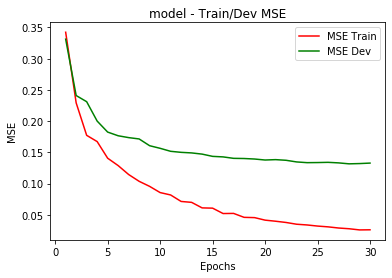

In [10]:
model=experiment(learning_rate=0.04,epochs=30,batch_size=256,steps=300,name='model')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14080256  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 14,080,513
Trainable params: 14,080,513
Non-trainable params: 0
_________________________________________________________________


## Persist

In [12]:
with open('/home/kvassay/data/z/models/E7/vectorizer_summary.pickle','wb') as f:
    pickle.dump(vectorizer_summary,f)
with open('/home/kvassay/data/z/models/E7/vectorizer_text.pickle','wb') as f:
    pickle.dump(vectorizer_text,f)
model.save('/home/kvassay/data/z/models/E7/keras_regressor.h5')